In [13]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
from torchvision import transforms
from PIL import Image

In [14]:
class ImageDataset(Dataset):
    def __init__(self, lr_folder, hr_folder, transform=None):
        self.lr_folder = lr_folder
        self.hr_folder = hr_folder
        self.transform = transform
        self.lr_images = os.listdir(lr_folder)
        self.hr_images = os.listdir(hr_folder)

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, index):
        lr_img = Image.open(os.path.join(self.lr_folder, self.lr_images[index]))
        hr_img = Image.open(os.path.join(self.hr_folder, self.hr_images[index]))
        if self.transform:
            lr_img = self.transform(lr_img)
            hr_img = self.transform(hr_img)
        return lr_img, hr_img

In [15]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

lr_folder = '/kaggle/input/celeba/data_celeb/data_celeb_blur'
hr_folder = '/kaggle/input/celeba/data_celeb/data_celeb'

In [16]:
dataset = ImageDataset(lr_folder, hr_folder, transform=transform)
train_set, eval_set = torch.utils.data.random_split(dataset, [0.9, 0.1])

In [17]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 3, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [18]:
# Hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 10
learning_rate = 5e-4
batch_size = 32
display_step = 500

loss_list = []
eval_list = []

In [19]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(eval_set, batch_size=batch_size, shuffle=False)

In [20]:
def weights_init(model):
    if isinstance(model, nn.Linear):
        torch.nn.init.xavier_uniform_(model.weight)

def train(dataloader, epoch):
    model.train()
    loss_epoch = 0
    for i, (data,targets) in enumerate(dataloader):
        data, targets = data.to(device), targets.to(device)

        # Clear gradient
        optimizer.zero_grad()
        outputs = model(data)

        # Backpropagation, compute gradients
        loss = loss_function(outputs, targets)
        loss.backward()

        # Apply gradients
        optimizer.step()
        
        # Lưu lại loss
        loss_epoch += loss.item()

        if i % display_step == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}'.format(
                epoch + 1, i, len(dataloader), 100.0 * i / len(dataloader), loss.item()
            ))

    return loss_epoch

# Định nghĩa hàm test
def test(dataloader):
    model.eval()
    loss_accumulate = 0
    with torch.no_grad():
        for i, (data, targets) in enumerate(dataloader):
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = loss_function(outputs, targets)
            loss_accumulate += loss
    
    avg_loss = loss_accumulate / len(dataloader)
    print('Loss avg.:', avg_loss)
    return avg_loss

In [21]:
model = SRCNN().to(device)
# Uncomment the below line 
# model.load_state_dict(torch.load(PATH))

model.apply(weights_init)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Print structure of model
print(model)

SRCNN(
  (conv1): Conv2d(3, 128, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU()
)


In [10]:
for epoch in range(epochs):
    loss_epoch = 0
    loss_epoch = train(train_loader, epoch)
    loss_list.append(loss_epoch)
    torch.cuda.empty_cache()
    eval_list.append(test(eval_loader))
    torch.cuda.empty_cache()
    print("Epoch {}: loss: {:.4f}, eval_loss: {:.4f}".format(epoch + 1, 
                                        loss_list[-1], eval_list[-1]))

Train Epoch: 1 [0/844 (0%)]	Loss: 1.6427
Train Epoch: 1 [500/844 (59%)]	Loss: 0.0268
Loss avg.: tensor(0.0268, device='cuda:0')
Epoch 1: loss: 32.1383, eval_loss: 0.0268
Train Epoch: 2 [0/844 (0%)]	Loss: 0.0307
Train Epoch: 2 [500/844 (59%)]	Loss: 0.0284
Loss avg.: tensor(0.0258, device='cuda:0')
Epoch 2: loss: 22.2437, eval_loss: 0.0258
Train Epoch: 3 [0/844 (0%)]	Loss: 0.0250
Train Epoch: 3 [500/844 (59%)]	Loss: 0.0259
Loss avg.: tensor(0.0248, device='cuda:0')
Epoch 3: loss: 21.5019, eval_loss: 0.0248
Train Epoch: 4 [0/844 (0%)]	Loss: 0.0226
Train Epoch: 4 [500/844 (59%)]	Loss: 0.0258
Loss avg.: tensor(0.0252, device='cuda:0')
Epoch 4: loss: 21.0126, eval_loss: 0.0252
Train Epoch: 5 [0/844 (0%)]	Loss: 0.0262
Train Epoch: 5 [500/844 (59%)]	Loss: 0.0522
Loss avg.: tensor(0.0242, device='cuda:0')
Epoch 5: loss: 21.5321, eval_loss: 0.0242
Train Epoch: 6 [0/844 (0%)]	Loss: 0.0278
Train Epoch: 6 [500/844 (59%)]	Loss: 0.0340
Loss avg.: tensor(0.0235, device='cuda:0')
Epoch 6: loss: 20.3055

In [11]:
torch.save(model.state_dict(), 'srcnn')

# Inference

In [22]:
model = SRCNN().to(device)
model.load_state_dict(torch.load('/kaggle/input/srcnn/pytorch/default/1/srcnn'))

/tmp/ipykernel_36/3880701940.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/srcnn/pytorch/default/1/srcnn'))


<All keys matched successfully>

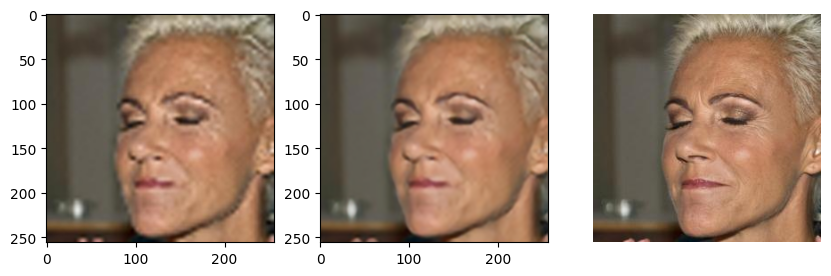

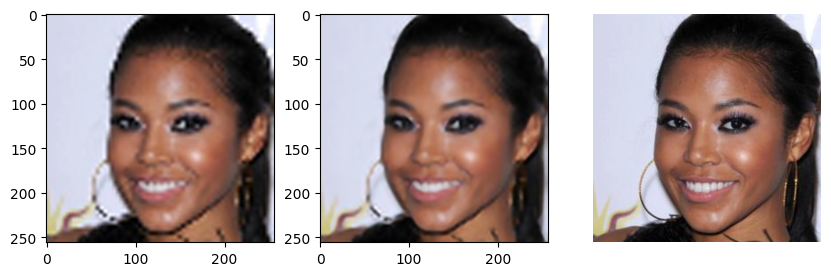

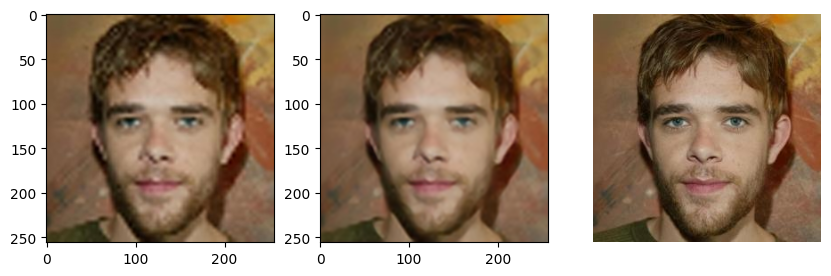

In [53]:
model.eval()
with torch.no_grad():
    for i, (data, targets) in enumerate(test_set):
        if i == 3:
            break
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        data = rescale(data)
        outputs = rescale(outputs)
        targets = rescale(targets)
        fig, ax = plt.subplots(1, 3, figsize=(10, 20))
        ax[0].imshow(data.permute(1, 2, 0).cpu())
        ax[1].imshow(outputs.permute(1, 2, 0).cpu())
        ax[2].imshow(targets.permute(1, 2, 0).cpu())
        plt.axis('off')

In [31]:
mean=torch.tensor([0.485, 0.456, 0.406]).unsqueeze(1).unsqueeze(2)
std= torch.tensor([0.229, 0.224, 0.225]).unsqueeze(1).unsqueeze(2)

def rescale(image):
    image = image * std.to(image.device) + mean.to(image.device)
    return image

In [42]:
path = '/kaggle/input/celeba/data_celeb/data_celeb_blur'

In [56]:
index = torch.tensor([2724, 23281, 27536,  6944]) 
images = [] 

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

for i in index: 
    image = Image.open(os.path.join(path, str(i.item()).zfill(5) + '.jpg'))
    image = transform(image).unsqueeze(0)
    images.append(image) 
                       
images = torch.cat(images, dim=0)

In [57]:
import torchvision

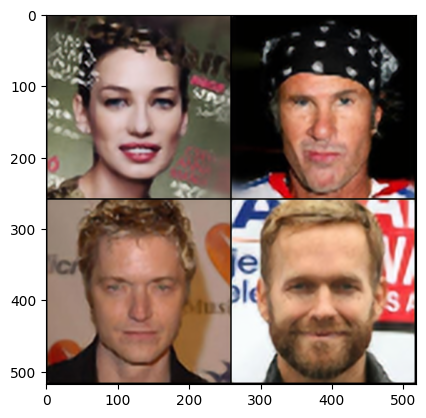

In [60]:
outputs = model(images.to(device))
outputs = rescale(outputs) 
outputs = torchvision.utils.make_grid(outputs, nrow=2) 
torchvision.utils.save_image(outputs, 'out.jpg')
plt.imshow(outputs.permute(1, 2, 0).cpu())
plt.savefig('img.jpg')